##### On this jupyter notebook, we are continuing our project. We are using the previous data wrangling project we already made to proceed with the modeling part. 


##### The modeling part is about to predict how different stock prices (Apple, American Airlines, and Tesla) will move as function of the time and oil.


##### We will be doing two regression types. Standard Regression and Gradient Boosting Regressor. On this step, we are comparing standarized data and data without standarization.


##### After doing the regressions, we will be performing ARIMAX and SARIMAX analysis. We would be comparing the different models, the outcomes, computing errors, comparing with test data, and finally doing forecasting.


##### Finally, we are concluding what model is better if we want to predict stock prices, the advantages and disadvantages of the models, etc.

In [1]:
#Import libraries
import pandas as pd
from pandas_datareader.data import DataReader
import datetime
import functools
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import kpss
import sys
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression

#### Insights from the data visualization

- As expected, Tesla stock is the less correlated with the oil price and American Airlines the most correlated with the oil price.


- Regarding the correlation result for American Airlines, we have a following hypothesis: If there is an increase on the oil price is because the increase of the demand. People around the world are traveling, so there is more customers on the airline industry, so therefore an increase on its revenues. If the company does well, investors acquire stocks, and therefore stock price also increases.


- For Tesla we have the following hypothesis: Oil prices roses the lowest value in their history. Tesla on the other hand, they have their highest stock price. To remark, oil prices are down and Tesla stock prices are high, so that's why we can support their negative correlation.  Same can be explained with Apple. 


- In the future, we could have the following hypothesis to what is going to happen between Tesla and its stock price: Oil prices could continue going down due to the use of fraking. People may not see Tesla as savings to their budget since it would be cheaper to just continue using regular gas, thereby Tesla revenues would go down and therefore their stock price as well. On the other hand, people may also want to help the work by making it more ecological can continue increasing Tesla revenues and therefore their stock price.


- JinkoSolar Holding is close to be not correlated with oil price. Therefore, we could conclude they are independ of how the oil price, but there is a small inclination that if oil price decrease, there would be an increase on the stocks. 


In [2]:
# Create a function that reads the data from yahoo finance
def stock_data(ticker, data_source, start, end):
    df = DataReader(ticker, data_source, start, end)['Adj Close']
    df = df.to_frame(ticker) 
    return df

In [3]:
#Define variables of data source, start and end date
start = datetime.date(2000,1,1)
end = datetime.date(2020,8,31)
source = 'yahoo'

In [4]:
#Get the data from the stocks we would like to make the data serie analysis
jks = stock_data('JKS', source, start, end)
aal = stock_data('AAL', source, start, end)
tsla = stock_data('TSLA', source, start, end)

In [5]:
#Read the oil price
oil = pd.read_csv('OPEC-ORB.csv', index_col = 0)
oil.index = pd.to_datetime(oil.index)
oil.rename( columns = {'Value': 'Oil Price'}, inplace = True)

In [6]:
# Define a function to merge the different data frames
def merge_df(df1, df2, df3, df4):
    df = [df1, df2, df3, df4]
    return functools.reduce(lambda left, right : pd.merge(left, right, how = 'inner', on = 'Date'), df)

In [7]:
#Data Frame we are going to make the times series
df = merge_df(oil, jks, aal,tsla).sort_values(by = 'Date', ascending = True)

# Modeling

#### Now we are in the modeling part. We are creating different X and Y arrays for each method. With method I'm referring to linear methods and sesonality methods

### Create the y and x arrays  for Regressions

In [8]:
#Divide between train and test data
#For time series, we would divide in consecutive train and test data set

In [9]:
#Reset Index to have date as categorical variables to run linear models
df2 = df.reset_index(inplace = True)

In [10]:
#Create the Date as categorical variables
df_date = pd.DataFrame()

df_date['Year'] = pd.Series(df['Date'])
df_date['Year'] = pd.DatetimeIndex(df_date['Year']).year

df_date['Month'] = pd.Series(df['Date'])
df_date['Month'] = pd.DatetimeIndex(df_date['Month']).month

df_date['Day'] = pd.Series(df['Date'])
df_date['Day'] = pd.DatetimeIndex(df_date['Day']).day

In [11]:
#Drop the current date column
df2 = df.drop(columns = 'Date', axis = 1)

In [12]:
#Concat the data frame data function as categorical variable with the stock and oil prices
df2 = pd.concat([df_date, df], axis = 1)

In [13]:
#See how the data frame looks like 
df2.head()

,Year,Month,Day,Date,Oil Price,JKS,AAL,TSLA
0,2010,6,29,2010-06-29,72.66,9.96,8.051013,4.778
1,2010,6,30,2010-06-30,72.49,9.70,8.117004,4.766
2,2010,7,1,2010-07-01,70.48,9.80,8.154712,4.392
3,2010,7,2,2010-07-02,69.63,10.21,7.721052,3.840
4,2010,7,6,2010-07-06,69.73,10.79,7.617351,3.222


In [14]:
#Create our X array for the regressions
X = df2[['Year','Month', 'Day', 'Oil Price']].values

In [15]:
#Create the y arrays
y = df2.iloc[:,4:].values

In [16]:
#Dependant Variable
y_oil = df2['Oil Price']
y_jks = df2['JKS']
y_aal = df2['AAL']
y_tsla = df2['TSLA']

#### Divide into train and test data

In [17]:
#Define the 80% of the data as train data and 20% as test data
q3 = int(len(y)*0.8)
q1 = int(len(y) *0.2)

In [18]:
#Define train function
def train(array):
    return array[:q3]

In [19]:
#Define test
def test(array):
    return array[q3:]

In [20]:
#X train and test array
X_train = train(X)
X_test = test(X)

In [21]:
# y train and test array
y_train = train(y)
y_test = test(y)

#### Define arrays for each stock

In [22]:
#Apple Stock
y_jks_train = [i[1] for i in y_train]
y_jks_test = [i[1] for i in y_test]

In [23]:
# American Airlines Stock
y_aal_train = [i[2] for i in y_train]
y_aal_test = [i[2] for i in y_test]

In [24]:
#Tesla Stock
y_tsla_train = [i[3] for i in y_train]
y_tsla_test = [i[3] for i in y_test]

## Standarization

I am also doing standarization in order to compare the results between standarized and not standarized data and see which model performs the best.

#### Standarization

In [25]:
#Import the library
from sklearn.preprocessing import StandardScaler

In [26]:
#Apply the scaler on the x_train
def scaler(array):
    scaler = StandardScaler()
    return scaler.fit_transform(array)

In [27]:
# Standarization 
X_train_scaler = scaler(X_train)
X_test_scaler = scaler(X_test)

## Regressions

#### We are defining functions that do the linear model. This is to make the code reusable as soon as I want to add a new stock or group of stocks.

In [28]:
#Define a function for the train score
def reg_train_score(model,x_train, y_train):
    return model.score(x_train, y_train)

In [29]:
#Define a function for the test score
def reg_test_score(model, x_test, y_test):
    return model.score(x_test, y_test)

In [30]:
#Define the function for normal regression use the models we want to use to predict the stock prices in the future
def regression_fit(model, x_train, y_train):
    reg = model()
    return reg.fit(x_train, y_train)

In [31]:
#Define a function for Gradient Boosting Regressor
def regression_fit_gradient(model, x_train, y_train, learning_rate, max_depth, n_estimators, tol):
    reg = model(learning_rate = learning_rate, n_estimators = n_estimators, max_depth = max_depth, tol = tol)
    return reg.fit(x_train, y_train)

In [32]:
#Define a function for the prediction
def regression_prediction(regression_fit, x_test):
    predict = regression_fit.predict(x_test)
    return predict

In [33]:
#Define a function to plot
def plot_regression(y_test, regression_prediction):
    plt.scatter(y_test, regression_prediction, color = 'black')
    x0 = min(y_test)
    x1 = max(y_test)
    y0 = min(regression_prediction)
    y1 = max(regression_prediction)
    plt.plot([x0,x1], [y0, y1], color = 'red')
    plt.xlabel('Actual Stock Price')
    plt.ylabel('Predicted Stock Price')
    plt.title('Actual vs Predicted Stock Price')
    return plt.show()

In [34]:
#Define a function to create a data frame for the coefficients
def coefficients(reg):
    coefficients = pd.DataFrame()
    coefficients['Variable'] = ['Year', 'Month', 'Day', 'Oil Price']
    coefficients['Coefficients'] = reg.coef_
    return coefficients

In [35]:
#Define a function for Cross Validation
def grid_search(model, param_grid, x_train, y_train,cv = 3):
    model = model()
    model_cv = GridSearchCV(model, param_grid, cv = 3)
    model_cv.fit(x_train, y_train)
    print('Based on the Cross Validation, the best parameters were:',
          model_cv.best_params_)

### JinkoSolar Holding

#### Standard Regression

In [36]:
#Create the model for Apple
reg = regression_fit(LinearRegression, X_train, y_jks_train)
#See the predictions
predict = regression_prediction(reg, X_test)

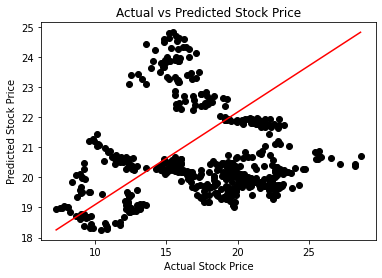

In [37]:
#Plot the results
plot_regression(y_jks_test, predict)

In [38]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train, y_jks_train), 
                                                                reg_test_score(reg, X_test, y_jks_test)))

The train and the test score are 0.09038467348536905 and -0.6632474535258568 respectively


In [39]:
mean_squared_error(y_tsla_test, predict)

12888.428057755003

In [40]:
#See the coefficients for the Standard Linear Regression
coefficients(reg = reg)

,Variable,Coefficients
0,Year,-0.052908
1,Month,0.011791
2,Day,-0.002653
3,Oil Price,-0.094551


#### Standard Regression with Standarization

In [41]:
#Create the model for Apple
reg = regression_fit(LinearRegression, X_train_scaler, y_jks_train)
#See the predictions
predict = regression_prediction(reg, X_test_scaler)

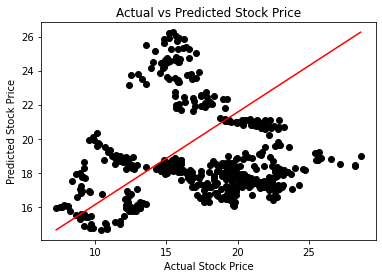

In [42]:
#Plot the results
plot_regression(y_jks_test, predict)

In [43]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train_scaler, y_jks_train), 
                                                                reg_test_score(reg, X_test_scaler, y_jks_test)))

The train and the test score are 0.09038467348536938 and -0.41424093892491487 respectively


In [44]:
mean_squared_error(y_tsla_test, predict)

13088.064025379654

#### Gradient Boosting Regressor

In [45]:
#Establish possible parameters to do the Grid Search
param_grid = {'learning_rate': [0.1, 1.0],
             'n_estimators': [100, 250],
             'max_depth': [3, 5],
             'tol': [0.0001, 0.01, 1]}

In [46]:
#Use the function we previously defined
warnings.simplefilter("ignore")
grid_search(GradientBoostingRegressor, param_grid, X_train, y_jks_train,cv = 3)

Based on the Cross Validation, the best parameters were: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'tol': 0.01}


In [47]:
#Fit the model
reg = regression_fit_gradient(GradientBoostingRegressor, X_train, y_jks_train, learning_rate =
                        0.1, max_depth = 3, n_estimators = 100, tol = 0.0001)
#Make the predictions
reg_pred = regression_prediction(reg, X_test)

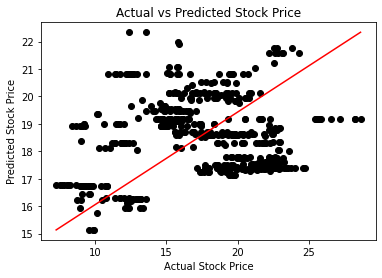

In [48]:
#Plot the results
plot_regression(y_jks_test, reg_pred)

In [49]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train, y_jks_train), 
                                                                reg_test_score(reg, X_test, y_jks_test)))

The train and the test score are 0.9349237071442831 and -0.0863403843787951 respectively


In [50]:
mean_squared_error(y_jks_test, reg_pred)

20.130786758317782

#### Gradient Boosting Classifier with Standarization

In [51]:
#Use the function we previously defined
warnings.simplefilter("ignore")
grid_search(GradientBoostingRegressor, param_grid, X_train_scaler, y_jks_train,cv = 3)

Based on the Cross Validation, the best parameters were: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'tol': 0.01}


In [52]:
#Fit the model
reg = regression_fit_gradient(GradientBoostingRegressor, X_train, y_jks_train, learning_rate =
                        0.1, max_depth = 3, n_estimators = 100, tol = 0.0001)
#Make the predictions
reg_pred = regression_prediction(reg, X_test)

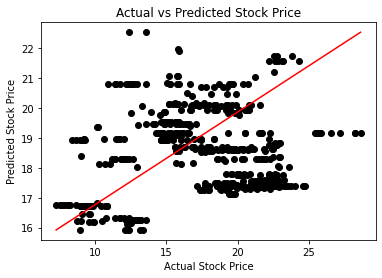

In [53]:
#Plot the results
plot_regression(y_jks_test, reg_pred)

In [54]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train_scaler, y_jks_train), 
                                                                reg_test_score(reg, X_test_scaler, y_jks_test)))

The train and the test score are -0.94671046775589 and -2.469791343152656 respectively


In [55]:
mean_squared_error(y_jks_test, reg_pred)

20.291968883418846

### American Airlines

#### Standard Regression

In [56]:
#Create the model for American Airlines
reg = regression_fit(LinearRegression, X_train, y_aal_train)
#See the predictions
predict = regression_prediction(reg, X_test)

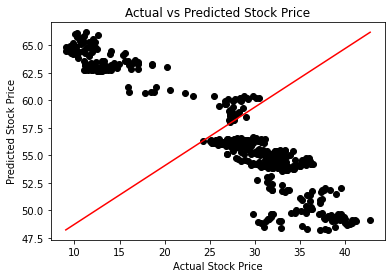

In [57]:
#Plot the results
plot_regression(y_aal_test, predict)

In [58]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train, y_aal_train), 
                                                                reg_test_score(reg, X_test, y_aal_test)))

The train and the test score are 0.8355231390268394 and -12.415163543793538 respectively


In [59]:
mean_squared_error(y_tsla_test, predict)

8038.288599704931

In [60]:
#See the coefficients for the Standard Linear Regression
coefficients(reg = reg)

,Variable,Coefficients
0,Year,5.076209
1,Month,0.215497
2,Day,0.018191
3,Oil Price,-0.121225


#### Standard Regression with Standarization

In [61]:
#Create the model for American Airlines
reg = regression_fit(LinearRegression, X_train_scaler, y_aal_train)
#See the predictions
predict = regression_prediction(reg, X_test_scaler)

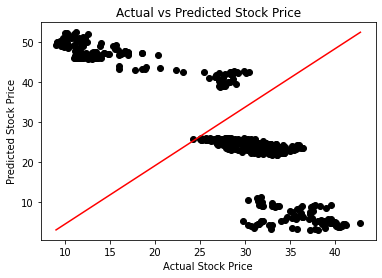

In [62]:
#Plot the results
plot_regression(y_aal_test, predict)

In [63]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train_scaler, y_aal_train), 
                                                                reg_test_score(reg, X_test_scaler, y_aal_test)))

The train and the test score are 0.8355231390268485 and -5.468351197927753 respectively


In [64]:
mean_squared_error(y_tsla_test, predict)

10515.636904831435

In [65]:
#See the coefficients for the Standard Linear Regression
coefficients(reg = reg)

,Variable,Coefficients
0,Year,12.096508
1,Month,0.732263
2,Day,0.159182
3,Oil Price,-3.390307


#### Gradient Boosting with Standarization

In [66]:
#Use the function we previously defined
warnings.simplefilter("ignore")
grid_search(GradientBoostingRegressor, param_grid, X_train, y_aal_train,cv = 3)

Based on the Cross Validation, the best parameters were: {'learning_rate': 1.0, 'max_depth': 5, 'n_estimators': 100, 'tol': 0.0001}


In [67]:
#Fit the model
reg = regression_fit_gradient(GradientBoostingRegressor, X_train, y_aal_train, learning_rate =
                        0.1, max_depth = 5, n_estimators = 250, tol = 1)
#Make the predictions
reg_pred = regression_prediction(reg, X_test)

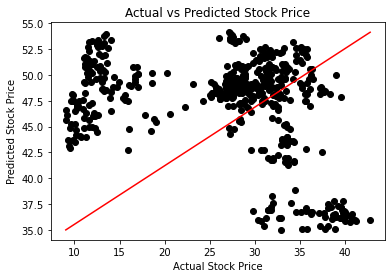

In [68]:
#Plot the results
plot_regression(y_aal_test, reg_pred)

In [69]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train, y_aal_train), 
                                                                reg_test_score(reg, X_test, y_aal_test)))

The train and the test score are 0.9989063059513702 and -5.769545435311315 respectively


In [70]:
mean_squared_error(y_aal_test, reg_pred)

545.1628870637513

#### Gradient Boosting with Standarization

In [71]:
#Use the function we previously defined
warnings.simplefilter("ignore")
grid_search(GradientBoostingRegressor, param_grid, X_train_scaler, y_aal_train,cv = 3)

Based on the Cross Validation, the best parameters were: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250, 'tol': 0.01}


In [72]:
#Fit the model
reg = regression_fit_gradient(GradientBoostingRegressor, X_train, y_aal_train, learning_rate =
                        0.1, max_depth = 5, n_estimators = 250, tol = 1)
#Make the predictions
reg_pred = regression_prediction(reg, X_test)

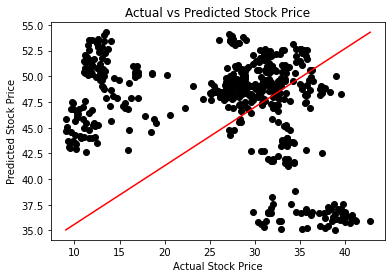

In [73]:
#Plot the results
plot_regression(y_aal_test, reg_pred)

In [74]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train, y_aal_train), 
                                                                reg_test_score(reg, X_test, y_aal_test)))

The train and the test score are 0.9989063059513702 and -5.74460276939072 respectively


In [75]:
mean_squared_error(y_aal_test, reg_pred)

543.1542121986105

### Tesla

#### Standard Regression

In [76]:
#Create the model for Tesla
reg = regression_fit(LinearRegression, X_train, y_tsla_train)
#See the predictions
predict = regression_prediction(reg, X_test)

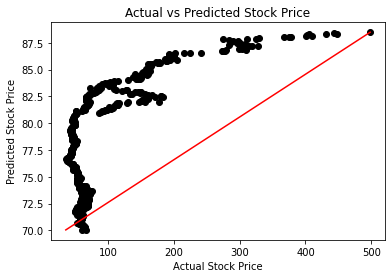

In [77]:
#Plot the results
plot_regression(y_tsla_test, predict)

In [78]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train, y_tsla_train), 
                                                                reg_test_score(reg, X_test, y_tsla_test)))

The train and the test score are 0.8648413079589319 and 0.01674577391830767 respectively


In [79]:
mean_squared_error(y_tsla_test, predict)

6511.297232384621

In [80]:
#See the coefficients for the Standard Linear Regression
coefficients(reg = reg)

,Variable,Coefficients
0,Year,8.994587
1,Month,0.938611
2,Day,0.033673
3,Oil Price,0.002201


#### Standard Regression with Standarization

In [81]:
#Create the model for Tesla
reg = regression_fit(LinearRegression, X_train_scaler, y_tsla_train)
#See the predictions
predict = regression_prediction(reg, X_test_scaler)

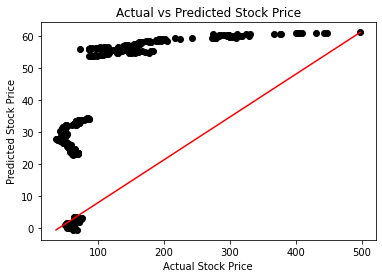

In [82]:
#Plot the results
plot_regression(y_tsla_test, predict)

In [83]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train_scaler, y_tsla_train), 
                                                                reg_test_score(reg, X_test_scaler, y_tsla_test)))

The train and the test score are 0.8648413079589468 and -0.4168864362085117 respectively


In [84]:
mean_squared_error(y_tsla_test, predict)

9382.892527655691

In [85]:
#See the coefficients for the Standard Linear Regression
coefficients(reg = reg)

,Variable,Coefficients
0,Year,21.433927
1,Month,3.189422
2,Day,0.294663
3,Oil Price,0.061557


#### Gradient Boosting Regressor

In [86]:
#Use the function we previously defined
warnings.simplefilter("ignore")
grid_search(GradientBoostingRegressor, param_grid, X_train, y_tsla_train,cv = 3)

Based on the Cross Validation, the best parameters were: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250, 'tol': 0.0001}


In [87]:
#Fit the model
reg = regression_fit_gradient(GradientBoostingRegressor, X_train, y_tsla_train, learning_rate =
                        1.0, max_depth = 3, n_estimators = 250, tol = 0.0001)
#Make the predictions
reg_pred = regression_prediction(reg, X_test)

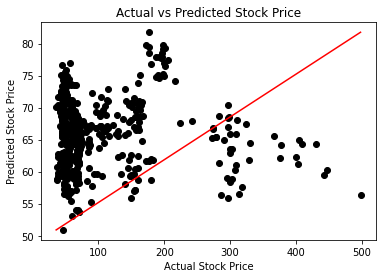

In [88]:
#Plot the results
plot_regression(y_tsla_test, reg_pred)

In [89]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train, y_tsla_train), 
                                                                reg_test_score(reg, X_test, y_tsla_test)))

The train and the test score are 0.9992235269883438 and -0.18697771210414005 respectively


In [90]:
mean_squared_error(y_tsla_test, reg_pred)

7860.393056763513

#### Gradient Boosting Regressorwith Standarization

In [91]:
#Use the function we previously defined
warnings.simplefilter("ignore")
grid_search(GradientBoostingRegressor, param_grid, X_train_scaler, y_tsla_train,cv = 3)

Based on the Cross Validation, the best parameters were: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250, 'tol': 0.01}


In [92]:
#Fit the model
reg = regression_fit_gradient(GradientBoostingRegressor, X_train, y_tsla_train, learning_rate =
                        1.0, max_depth = 3, n_estimators = 250, tol = 0.0001)
#Make the predictions
reg_pred = regression_prediction(reg, X_test)

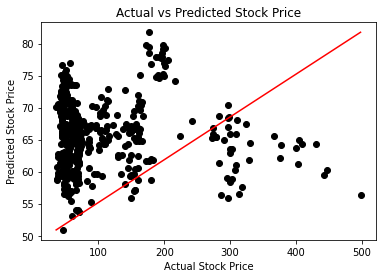

In [93]:
#Plot the results
plot_regression(y_tsla_test, reg_pred)

In [94]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train_scaler, y_tsla_train), 
                                                                reg_test_score(reg, X_test_scaler, y_tsla_test)))

The train and the test score are -0.7142101419230493 and -1.1093376146403617 respectively


In [95]:
mean_squared_error(y_tsla_test, reg_pred)

7879.657202205451

#### Insights from the linear regression

- By doing this standard regression, we can conclude that models such as Lasso or Ridge would not work well to anticipate the future stock price. It fits well the training data, but it doesn't do well on the test data. This could also be supported because the higher increases occurred after 2018. 


- We may need to rely more on the times series analysis we are making on the next steps.

## Constant model

### JKS

In [96]:
pred = []
num = y_jks_train[-1]
for i in range(1,513):
    pred.append(num)
    continue

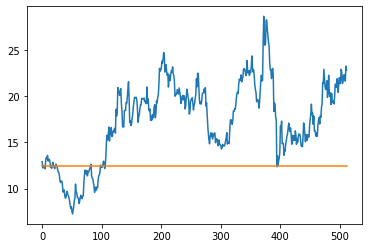

In [97]:
plt.plot(y_jks_test)
plt.plot(pred)
plt.show()

In [98]:
mean_squared_error(y_jks_test, pred)

42.875611800460874

### AAL

In [99]:
pred = []
num = y_aal_train[-1]
for i in range(1,513):
    pred.append(num)
    continue

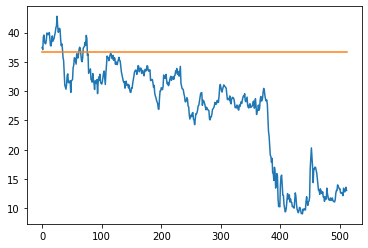

In [100]:
plt.plot(y_aal_test)
plt.plot(pred)
plt.show()

In [101]:
mean_squared_error(y_aal_test, pred)

179.19719903529386

### TSLA

In [102]:
pred = []
num = y_tsla_train[-1]
for i in range(1,513):
    pred.append(num)
    continue

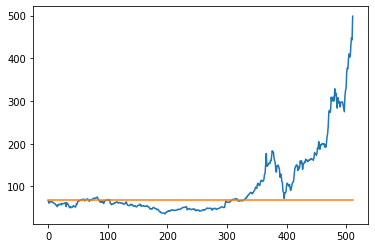

In [103]:
plt.plot(y_tsla_test)
plt.plot(pred)
plt.show()

In [104]:
mean_squared_error(y_aal_test, pred)

1755.6526242056366

### Insights

##### Regressions are very bad model to make predictions because I get even more accuracy, and less error by just assuming a constant model with the last stock price.

##### We should completely go to the times series analysis this time to make our conclusions about what to do with the stocks.

## Times Series Analysis

In this step, we are making a times series analysis in order to predict the different stock prices. This is the methodology we are following:

- Check if the data is stationary by using kpss.

- If data is not stationalry, we are making them stationary using logarithms. 

- Do a Cross Validation to see the best order for the models. For the Autocorrelation plots we can imply order = (1,0,0) would be the best.

- After we are creating the SARIMAX and ARIMA model. 

In [105]:
def transform_log(y):
    return np.log(y)

### Check if the data is stationary

In [106]:
#Firstly we need to set a higher recursion limit
sys.setrecursionlimit(10000)

In [107]:
#Check if Oil is Stationary
kpss(y_oil)

(5.440463061940448,
 0.01,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [108]:
#Check if Apple Stock Price is stationary
kpss(y_jks)

(0.6309868504740087,
 0.01981937722963557,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [109]:
#Check if American Airlines data is stationary
kpss(y_aal)

(4.5799140336336945,
 0.01,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [110]:
#Check if Tesla Stock Price is stationary
kpss(y_tsla)

(4.741163872953131,
 0.01,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### Insights

- For all of the stocks, the data is not stationary since we got a p-value less than 0.05 for all of them. Thereore, we need to make the data stationary by using np.log

### Making Data Stationary

In [111]:
# Oil p-value
y_oil_log = transform_log(y_oil)
kpss(y_oil_log.diff().dropna())

(0.059785057821304374,
 0.1,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [112]:
# Apple p-value
y_jks_log = transform_log(y_jks)
kpss(y_jks_log.diff().dropna())

(0.05689604830260006,
 0.1,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [113]:
# American Airlines p-value
y_aal_log = transform_log(y_aal)
kpss(y_aal_log.diff().dropna())

(0.3961933229944284,
 0.0787959814679188,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [114]:
# Tesla p-value
y_tsla_log = transform_log(y_tsla)
kpss(y_tsla_log.diff().dropna())

(0.18840587005251933,
 0.1,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Now, all the data is stationary since for all of them we have p-values higher than 0.05

## Define the X and y arrays for the stationary models

In [115]:
df_log = pd.DataFrame()
df_log['Date'] = df['Date']
df_log['Oil Price'] = y_oil_log
df_log['JKS'] = y_jks_log
df_log['AAL'] = y_aal_log
df_log['TSLA'] = y_tsla_log
df_log.set_index('Date', inplace = True)

In [116]:
df_log_train = df_log.loc['2010-06-29':'2019-01-01']
df_log_test = df_log['2019-01-01':]

In [117]:
#Define arrays for ARIMA
# Oil Price
y_oil_train_log = df_log_train['Oil Price']
y_oil_test_log = df_log_test['Oil Price']

In [118]:
#JKS
y_jks_train_log = df_log_train['JKS']
y_jks_test_log = df_log_test['JKS']

In [119]:
#American Airlines
y_aal_train_log = df_log_train['AAL']
y_aal_test_log = df_log_test['AAL']

In [120]:
#American Airlines
y_tsla_train_log = df_log_train['TSLA']
y_tsla_test_log = df_log_test['TSLA']

### ARIMA Functions

In [121]:
#Model to do the type of cross validation
def arima_model_prediction_oil(array1, array2, order):
    mod = ARIMA(endog = array1, order = order, exog = None)
    mod_fit = mod.fit(disp = 0)
    pred = mod_fit.forecast(steps = len(array2))[0]
    return pred

In [122]:
def arima_forecast_oil(array1, order):
    mod = ARIMA(endog = array1, order = order, exog = None)
    mod_fit = mod.fit(disp = 0)
    pred = mod_fit.forecast(steps = 865, alpha = 0.05)[0]
    return pred

In [123]:
graph_test = pd.DataFrame(y_oil_test_log).reset_index(drop = True)
def arima_comparison_oil(array1, order):
    model = ARIMA(endog = array1, order = order, exog = None)
    model_fit = model.fit()
    pred = model_fit.predict(start = 2139, end = 2558)
    graph_pred = pd.DataFrame(pred).reset_index(drop = True)
    plt.plot(graph_test)
    plt.plot(graph_pred)
    return plt.show()

In [124]:
# Create a function that gets the scores for each order.
#We are picking the order that has the least error
def arima_validation_oil(y_train, y_test):
    for p in p_value:
        for q in q_value:
            for d in d_value:
                try:
                    pred = arima_model_prediction_oil(array1 = y_train, array2 = y_test,order = (p,q,d))
                    error = mean_squared_error(y_test, pred)
                    print('({}, {}, {}) : Error of: {}'.format(p, q, d, error))
                except:
                    pass

## Oil Price

In [125]:
#Define Arrays for Cross Validation
train = y_oil_train_log[q1:]
test = y_oil_train_log[:q1]

In [126]:
#Set a range of values to check out the best order for ARIMA
p_value = list(range(0,3))
q_value = list(range(0,3))
d_value = list(range(0,3))
s_value = list(range(0,3))

In [127]:
arima_validation_oil(y_train = train, y_test = test)

(0, 0, 0) : Error of: 0.18819632737234923
(0, 0, 1) : Error of: 0.18830214765643252
(0, 1, 0) : Error of: 0.6226814473291176
(0, 1, 1) : Error of: 0.6355775693626695
(0, 1, 2) : Error of: 0.6350667651088996
(0, 2, 0) : Error of: 30.728358471645723
(0, 2, 1) : Error of: 10.477378189716596
(0, 2, 2) : Error of: 3.4540404203569333
(1, 0, 0) : Error of: 0.37683955071043235
(1, 0, 1) : Error of: 0.3587084485296662
(1, 0, 2) : Error of: 0.3564015953797467
(1, 1, 0) : Error of: 0.6313465577572582
(1, 1, 1) : Error of: 0.6351646967377882
(1, 1, 2) : Error of: 0.635557751256973
(1, 2, 0) : Error of: 0.39658418374055554
(1, 2, 1) : Error of: 1.2261488346617273
(1, 2, 2) : Error of: 2.8318528467783346
(2, 0, 0) : Error of: 0.3491477886247062
(2, 0, 1) : Error of: 0.3567248238761433
(2, 0, 2) : Error of: 0.3557324180579138
(2, 1, 0) : Error of: 0.6350195650260233
(2, 1, 1) : Error of: 0.635232663285219
(2, 1, 2) : Error of: 0.6354963063873766
(2, 2, 0) : Error of: 6.9139699289178695
(2, 2, 1) : Er

- Regarding the oil, we got the least error on the ARIMA order with order = (1,0,2)

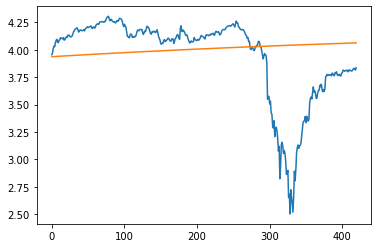

In [128]:
#Compare test and predictions with the order
arima_comparison_oil(array1 = y_oil_train_log, order = (1,0,1))

In [129]:
df3 = df_log_train.reset_index(drop = True)

In [130]:
#Make Projections 
oil_forecast = arima_forecast_oil(array1 = y_oil_train_log, order = (1,0,2))
df_oil_forecast = pd.DataFrame({'Oil Price': oil_forecast, 'Time': [i for i in range(2139, 2139 + 865)]})
df_oil_forecast = df_oil_forecast.set_index('Time')
oil_arima_graph = pd.concat([pd.DataFrame(df3['Oil Price']), df_oil_forecast], axis = 0)

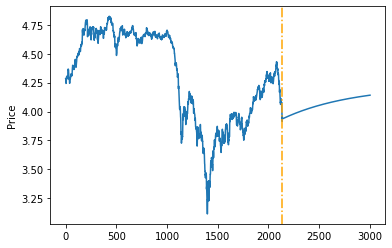

In [131]:
#Plot the projections
plt.plot(oil_arima_graph)
plt.ylabel('Price')
plt.axvline(2138, color = 'orange', linestyle = '-.')
plt.show()

#### From the Oil Price, after doing the forecast, we are seeing the oil price is expecting to increase in the futre and be stable (This may not be totally true due to the previous oil behavior that is characterized to be very volatil).

## Stocks

In [132]:
def arima_model_stock_pred(array1, order, array2):
    mod = ARIMA(endog = array1, order = order, exog = train)
    mod_fit = mod.fit(disp = 0)
    pred = mod_fit.forecast(steps = len(array2), exog = test)[0]
    return pred

In [133]:
# Create a function to do the cross validation for stocks
def arima_validation_stock(y_train, y_test):
    for p in p_value:
        for q in q_value:
            for d in d_value:
                try:
                    pred = arima_model_stock_pred(array1 = y_train, order = (p,q,d), array2 = y_test)
                    error = mean_squared_error(y_test, pred)
                    print('({}, {}, {}) : Error of: {}'.format(p, q, d, error))
                except:
                    pass

In [134]:
def arima_forecast_stock(array1, order):
    mod = ARIMA(endog = array1, order = order, exog = df_log_train['Oil Price'])
    mod_fit = mod.fit(disp = 0)
    pred = mod_fit.forecast(steps = 865, alpha = 0.05, exog = oil_forecast)[0]
    return pred

In [135]:
graph_jks_test = pd.DataFrame(y_jks_test_log).reset_index(drop = True)
graph_aal_test = pd.DataFrame(y_aal_test_log).reset_index(drop = True)
graph_tsla_test = pd.DataFrame(y_tsla_test_log).reset_index(drop = True)

def arima_comparison_stock(array1, order, test):
    model = ARIMA(endog = array1, order = order, exog = df_log_train['Oil Price'])
    model_fit = model.fit()
    pred = model_fit.predict(start = 2139, end = 2558, exog = y_oil_test_log)
    graph_pred = pd.DataFrame(pred).reset_index(drop = True)
    plt.plot(test)
    plt.plot(graph_pred)
    return plt.show()

## JKS

### ARIMA

In [136]:
#Define Arrays for Cross Validation
train_jks = y_jks_train_log[q1:].values
test_jks = y_jks_train_log[:q1].values

In [137]:
arima_validation_stock(y_train = train_jks, y_test = test_jks)

(0, 0, 0) : Error of: 0.4759268678511311
(0, 0, 1) : Error of: 0.4758071727795804
(0, 1, 0) : Error of: 1.0575718215522971
(0, 1, 1) : Error of: 1.0572052747594134
(0, 1, 2) : Error of: 1.0571380205636882
(0, 2, 0) : Error of: 135.85408833064236
(0, 2, 1) : Error of: 2.4054144817509995
(1, 0, 0) : Error of: 0.541847431040153
(1, 0, 1) : Error of: 0.5419838978375601
(1, 0, 2) : Error of: 0.5425934682891246
(1, 1, 0) : Error of: 1.0571838265621751
(1, 1, 1) : Error of: 1.0572638386341702
(1, 2, 0) : Error of: 152.4767187133646
(1, 2, 1) : Error of: 2.381657696775298
(1, 2, 2) : Error of: 2.499304468479781
(2, 0, 0) : Error of: 0.5419864163891036
(2, 0, 1) : Error of: 0.5421986885872089
(2, 0, 2) : Error of: 0.5413802382078418
(2, 1, 0) : Error of: 1.0570832196749889
(2, 1, 1) : Error of: 1.0569397552063222
(2, 2, 0) : Error of: 55.60103058551858
(2, 2, 1) : Error of: 2.4514749713730275
(2, 2, 2) : Error of: 2.2799087229576585


Order (1,0,0)

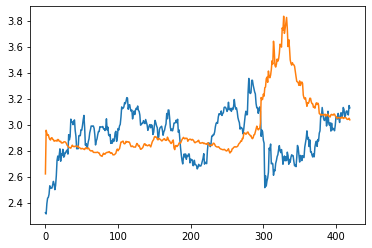

In [138]:
#Comparison between test and predicted values
arima_comparison_stock(array1 = y_jks_train_log, order = (0,0,1), test = graph_jks_test)

##### From the JKS stock, we are seeing that the predicted and the test data behave very similar, so we are going to proceed to make our forecast.

In [139]:
#Make Projections 
forecast = arima_forecast_stock(array1 = y_jks_train_log, order = (0,0,1))
forecast = pd.DataFrame({'JKS': forecast, 'Time': [i for i in range(2139, 2139 + 865)]})
forecast = forecast.set_index('Time')
graph_arima_jks = pd.concat([pd.DataFrame(df_log_train['JKS']).reset_index(drop = True), forecast], axis = 0)

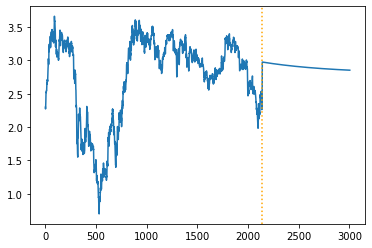

In [140]:
#Plot the projectioms
plt.plot(graph_arima_jks)
plt.axvline(2139, color = 'Orange', linestyle = 'dotted')
plt.show()

#### From the forecast we can conclude that JKS stock may tend to be constant.

### American Airlines

In [141]:
#Define Arrays for Cross Validation
train_aal = y_aal_train_log[q1:].values
test_aal = y_aal_train_log[:q1].values

In [142]:
arima_validation_stock(y_train = train_aal, y_test = test_aal)

(0, 0, 0) : Error of: 1.2994789972673175
(0, 0, 1) : Error of: 1.3079093641160282
(0, 1, 0) : Error of: 3.0406682858809737
(0, 1, 1) : Error of: 3.040073490259293
(0, 1, 2) : Error of: 3.0387382461390398
(0, 2, 0) : Error of: 7.345470870854624
(0, 2, 1) : Error of: 0.7411231164092583
(0, 2, 2) : Error of: 0.7586779443934224
(1, 0, 0) : Error of: 1.8044602226417885
(1, 0, 1) : Error of: 1.7986714540783308
(1, 0, 2) : Error of: 1.7924399007022473
(1, 1, 0) : Error of: 3.0399641114044287
(1, 1, 1) : Error of: 3.0400214461409716
(1, 2, 0) : Error of: 6.247358373103994
(1, 2, 1) : Error of: 0.3329105347930652
(1, 2, 2) : Error of: 0.8111886039920349
(2, 0, 0) : Error of: 1.797946544365783
(2, 0, 1) : Error of: 1.7944304077098778
(2, 0, 2) : Error of: 1.792432047684688
(2, 1, 0) : Error of: 3.038950356258118
(2, 1, 1) : Error of: 3.035818314844714
(2, 1, 2) : Error of: 3.036228176250354
(2, 2, 0) : Error of: 1.3985302775351571
(2, 2, 1) : Error of: 1.0784902826077631
(2, 2, 2) : Error of: 1.

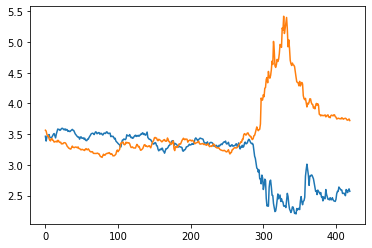

In [143]:
# Comparison between test and predictions
arima_comparison_stock(array1 = y_aal_train_log, order = (0,0,1), test = graph_aal_test)

#### From this comparison, the predictions and the test data were moving very similar. However, unexpected events such as covid (there is no model that would take into consideration this) made the stock prediction and the test move differently. 

In [144]:
#Make Projections 
forecast = arima_forecast_stock(array1 = y_aal_train_log, order = (0,0,1))
forecast = pd.DataFrame({'AAL': forecast, 'Time': [i for i in range(2139, 2139 + 865)]})
forecast = forecast.set_index('Time')
graph_arima_aal = pd.concat([pd.DataFrame(df_log_train['AAL']).reset_index(drop = True), forecast], axis = 0)

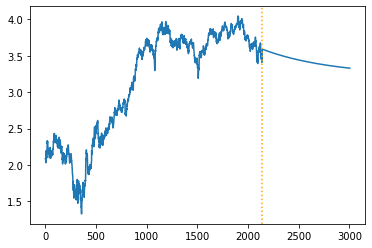

In [145]:
#Plot the projectioms
plt.plot(graph_arima_aal)
plt.axvline(2139, color = 'Orange', linestyle = 'dotted')
plt.show()

#### From the forecast we are seeing that the American Airlines stock may continue decreasing over time based on previous behavior.

### Tesla

In [146]:
#Define Arrays for Cross Validation
train_tsla = y_tsla_train_log[q1:].values
test_tsla = y_tsla_train_log[:q1].values

In [147]:
arima_validation_stock(y_train = train_tsla, y_test = test_tsla)

(0, 0, 0) : Error of: 2.480252382053331
(0, 0, 1) : Error of: 2.498714395965215
(0, 1, 0) : Error of: 10.430010437745274
(0, 1, 1) : Error of: 10.428251914657967
(0, 1, 2) : Error of: 10.427532342550922
(0, 2, 0) : Error of: 223.32967861660444
(0, 2, 1) : Error of: 4.6996407277651535
(1, 0, 0) : Error of: 6.2826871965230895
(1, 0, 1) : Error of: 6.2928549026893315
(1, 0, 2) : Error of: 6.29068626646188
(1, 1, 0) : Error of: 10.427940060124289
(1, 1, 1) : Error of: 10.427956691097988
(1, 2, 0) : Error of: 51.92470643270327
(1, 2, 1) : Error of: 4.706706224006901
(1, 2, 2) : Error of: 6.628384646580777
(2, 0, 0) : Error of: 6.292866345609433
(2, 0, 1) : Error of: 6.292604057876451
(2, 0, 2) : Error of: 6.300910839366322
(2, 1, 0) : Error of: 10.427538984822963
(2, 1, 1) : Error of: 10.426753423259067
(2, 2, 0) : Error of: 31.186336783816706
(2, 2, 1) : Error of: 6.926323283785957
(2, 2, 2) : Error of: 5.417793728646502


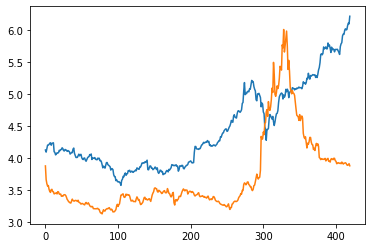

In [148]:
# Comparison between test and predictions
arima_comparison_stock(array1 = y_tsla_train_log, order = (0,0,1), test = graph_tsla_test)

#### Stock test data and predictions were moving similarly. However, when our predictions said stocks were going down, tesla stock continued booming. Tesla Stock is very difficult to analyze by any model because of its volatility. 

In [149]:
#Make Projections 
forecast = arima_forecast_stock(array1 = y_tsla_train_log, order = (0,0,1))
forecast = pd.DataFrame({'TSLA': forecast, 'Time': [i for i in range(2139, 2139 + 865)]})
forecast = forecast.set_index('Time')
graph_arima_tsla = pd.concat([pd.DataFrame(df_log_train['TSLA']).reset_index(drop = True), forecast], axis = 0)

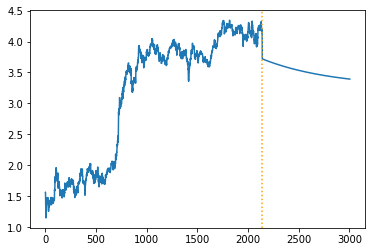

In [150]:
#Plot the projectioms
plt.plot(graph_arima_tsla)
plt.axvline(2139, color = 'Orange', linestyle = 'dotted')
plt.show()

#### From the forecast we can observe Tesla Stock may tend to fall. but not dramatically and then it would be stable.

### SARIMAX Oil

In [151]:
#Model to do the type of cross validation
def sarimax_model_prediction_oil(array1, array2, order1, order2):
    mod = SARIMAX(endog = array1, order = order1, seasonal_order = order2, exog = None)
    mod_fit = mod.fit(disp = 0)
    pred = mod_fit.forecast(steps = len(array2))
    return pred

In [152]:
# Create a function that gets the scores for each order.
#We are picking the order that has the least error
def sarimax_validation_oil(y_train, y_test):
    for p in p_value:
        for q in q_value:
            for d in d_value:
                for s in s_value:
                    try:
                        pred = sarimax_model_prediction_oil(array1 = y_train, array2 = y_test,
                                                        order1 = (p,q,d), order2 = (p,q,d,s))
                        error = mean_squared_error(y_test, pred)
                        print('({}, {}, {}, {}) : Error of: {}'.format(p, q, d, s, error))
                    except:
                        pass

In [153]:
def sarimax_comparison_oil(array1, order1, order2):
    model = SARIMAX(endog = array1, order = order1, seasonal_order = order2, exog = None)
    model_fit = model.fit()
    pred = model_fit.predict(start = 2139, end = 2558)
    graph_pred = pd.DataFrame(pred).reset_index(drop = True)
    plt.plot(graph_test)
    plt.plot(graph_pred)
    return plt.show()

In [154]:
def sarimax_forecast_oil(array1, order1, order2):
    mod = SARIMAX(endog = array1, order = order1, seasonal_order = order2, exog = None)
    mod_fit = mod.fit(disp = 0)
    pred = mod_fit.forecast(steps = 865, alpha = 0.05)
    return pred

### Oil

In [155]:
sarimax_validation_oil(y_train = train, y_test = test)

(0, 0, 0, 0) : Error of: 21.232127557549376
(0, 0, 0, 1) : Error of: 21.232127557549376
(0, 0, 0, 2) : Error of: 21.232127557549376
(0, 0, 1, 0) : Error of: 21.187141161355388
(0, 0, 1, 1) : Error of: 21.187141161355388
(0, 0, 1, 2) : Error of: 21.160308455486117
(0, 0, 2, 0) : Error of: 21.172595155094093
(0, 0, 2, 1) : Error of: 21.172595155094093
(0, 0, 2, 2) : Error of: 21.09826878035448
(0, 1, 0, 1) : Error of: 26.93053468790763
(0, 1, 0, 2) : Error of: 12.768745322408058
(0, 1, 1, 1) : Error of: 4.425388342483944
(0, 1, 1, 2) : Error of: 0.7862949760066305
(0, 1, 2, 1) : Error of: 22.24145124872347
(0, 1, 2, 2) : Error of: 8.360385760130717
(0, 2, 0, 1) : Error of: 1677608441469.1333
(0, 2, 0, 2) : Error of: 17343606711.444572
(0, 2, 1, 1) : Error of: 63.89809312368498
(0, 2, 1, 2) : Error of: 40.730440394139684
(0, 2, 2, 1) : Error of: 16.253233239736584
(0, 2, 2, 2) : Error of: 51.117257989759295
(1, 0, 0, 0) : Error of: 25.222185122305955
(1, 0, 0, 1) : Error of: 25.2221851223

Order = (1,0,2,2)

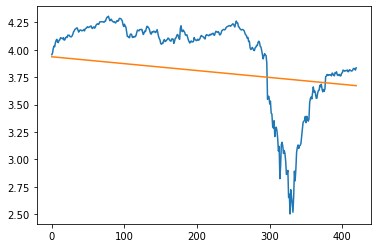

In [156]:
#Comparison between predicted and test data
sarimax_comparison_oil(array1 = y_oil_train_log, order1 = (0,1,1) , order2 = (0,1,1,2))

#### Comparing the prediction and the test data, looks the prediction follows the general trend.

In [157]:
# Create a data frame with all the forecast
graph_sarimax = pd.DataFrame()

In [158]:
oil_forecast_sarimax = sarimax_forecast_oil(y_oil_train_log, order1 = (0,1,1,), order2 = (0,1,1,2))
df_oil_forecast = pd.DataFrame({'Oil Price': oil_forecast_sarimax, 'Time': [i for i in range(2139, 2139 + 865)]})
df_oil_forecast = df_oil_forecast.set_index('Time')
graph_oil_sarimax = pd.concat([pd.DataFrame(df_log_train['Oil Price']).reset_index(drop = True), 
                               df_oil_forecast], axis = 0)

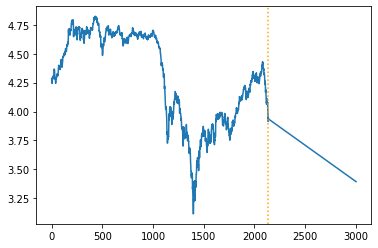

In [159]:
#Plot the projectioms
plt.plot(graph_oil_sarimax)
plt.axvline(2139, color = 'Orange', linestyle = 'dotted')
plt.show()

#### Same than ARIMA, SARIMAX tells us that the oil Price will go down, but dramatically.

## Stocks

In [160]:
def sarimax_model_prediction(array1, array2, order1, order2):
    mod = SARIMAX(endog = array1, order = order1, seasonal_order = order2, exog = train.reshape(-1,1))
    mod_fit = mod.fit(disp = 0)
    pred = mod_fit.forecast(steps = len(array2), exog = test.reshape(-1,1))
    return pred

In [161]:
# Create a function that gets the scores for each order.
#We are picking the order that has the least error
def sarimax_validation(y_train, y_test):
    for p in p_value:
        for q in q_value:
            for d in d_value:
                for s in s_value:
                    try:
                        pred = sarimax_model_prediction_oil(array1 = y_train, array2 = y_test,
                                                        order1 = (p,q,d), order2 = (p,q,d,s))
                        error = mean_squared_error(y_test, pred)
                        print('({}, {}, {}, {}) : Error of: {}'.format(p, q, d, s, error))
                    except:
                        pass

In [162]:
graph_jks_test = pd.DataFrame(y_jks_test_log).reset_index(drop = True)
graph_aal_test = pd.DataFrame(y_aal_test_log).reset_index(drop = True)
graph_tsla_test = pd.DataFrame(y_tsla_test_log).reset_index(drop = True)
def sarimax_comparison_test(array1, order1, order2, test):
    model = SARIMAX(endog = array1, order = order1, seasonal_order = order2, exog = df_log_train['Oil Price'].values.
                   reshape(-1,1))
    model_fit = model.fit()
    pred = model_fit.predict(start = 2139, end = 2558, exog = y_oil_test_log.values.reshape(-1,1))
    graph_pred = pd.DataFrame(pred).reset_index(drop = True)
    plt.plot(test)
    plt.plot(graph_pred)
    return plt.show()    


In [163]:
def sarimax_forecast_stock(array1, order1, order2):
    mod = SARIMAX(endog = array1, order = order1, seasonal_order = order2, exog = df_log_train['Oil Price'].
                  values.reshape(-1,1))
    mod_fit = mod.fit(disp = 0)
    pred = mod_fit.forecast(steps = 865, alpha = 0.05, exog = oil_forecast.reshape(-1,1))
    return pred

### JKS

In [164]:
sarimax_validation(y_train = train_jks, y_test = test_jks)

(0, 0, 0, 0) : Error of: 7.234460351039023
(0, 0, 0, 1) : Error of: 7.234460351039023
(0, 0, 0, 2) : Error of: 7.234460351039023
(0, 0, 1, 0) : Error of: 7.220752041568527
(0, 0, 1, 1) : Error of: 7.220752041568527
(0, 0, 1, 2) : Error of: 7.21557296122289
(0, 0, 2, 0) : Error of: 7.208016582543581
(0, 0, 2, 1) : Error of: 7.208016582543581
(0, 0, 2, 2) : Error of: 7.199761744800584
(0, 1, 0, 1) : Error of: 13.236701083388793
(0, 1, 0, 2) : Error of: 24.117450927976353
(0, 1, 1, 1) : Error of: 11.072501425493186
(0, 1, 1, 2) : Error of: 0.7797455060830841
(0, 1, 2, 1) : Error of: 21.67244166664605
(0, 1, 2, 2) : Error of: 0.8403503750473851
(0, 2, 0, 1) : Error of: 551313460402.9423
(0, 2, 0, 2) : Error of: 128782832743.28635
(0, 2, 1, 1) : Error of: 90.1938476308205
(0, 2, 1, 2) : Error of: 78.62768433383877
(0, 2, 2, 1) : Error of: 51.453243683858176
(0, 2, 2, 2) : Error of: 38.62189382504244
(1, 0, 0, 0) : Error of: 6.655830275580516
(1, 0, 0, 1) : Error of: 6.655830275580516
(1, 0,

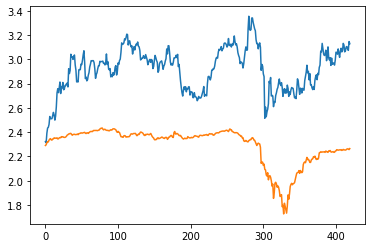

In [165]:
#Comparison
sarimax_comparison_test(array1 = y_jks_train_log, order1 = (0,1,1), order2 = (0,1,1,2), test = graph_jks_test)

#### From the comparison, we see very similary behavior when stock is whether going up or down.

In [166]:
jks_forecast_sarimax = sarimax_forecast_stock(array1 = y_jks_train_log, order1 = (0,1,1), order2 = (0,1,1,2))
df_jks_forecast = pd.DataFrame({'Price': jks_forecast_sarimax, 'Time': [i for i in range(2139, 2139 + 865)]})
df_jks_forecast = df_jks_forecast.set_index('Time')
graph_jks_sarimax = pd.concat([pd.DataFrame(df_log_train['JKS']).reset_index(drop = True), df_jks_forecast], axis = 0)

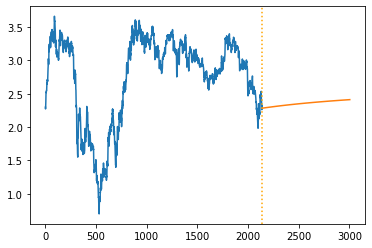

In [167]:
#Plot the projectioms
plt.plot(graph_jks_sarimax)
plt.axvline(2139, color = 'Orange', linestyle = 'dotted')
plt.show()

#### SARIMAX is telling us stock price may increase in the future. It is not going to boom though. It may be a very controlled increas en the stock price.

### AAL

In [168]:
# Do the validation
sarimax_validation(y_train = train_aal, y_test = test_aal)

(0, 0, 0, 0) : Error of: 4.281529205671078
(0, 0, 0, 1) : Error of: 4.281529205671078
(0, 0, 0, 2) : Error of: 4.281529205671078
(0, 0, 1, 0) : Error of: 4.267973684432081
(0, 0, 1, 1) : Error of: 4.267973684432081
(0, 0, 1, 2) : Error of: 4.25986111632135
(0, 0, 2, 0) : Error of: 4.257747774027041
(0, 0, 2, 1) : Error of: 4.257747774027041
(0, 0, 2, 2) : Error of: 4.2476313977877185
(0, 1, 0, 1) : Error of: 0.9522050505583907
(0, 1, 0, 2) : Error of: 1.230224542350889
(0, 1, 1, 1) : Error of: 1.4534658985658662
(0, 1, 1, 2) : Error of: 1.9273078532315677
(0, 1, 2, 1) : Error of: 0.4790108944157858
(0, 1, 2, 2) : Error of: 1.956144899404104
(0, 2, 0, 1) : Error of: 233228603765.00113
(0, 2, 0, 2) : Error of: 64729548071.92484
(0, 2, 1, 1) : Error of: 0.8524949067848056
(0, 2, 1, 2) : Error of: 0.3122590421347465
(0, 2, 2, 1) : Error of: 113.23594985113716
(0, 2, 2, 2) : Error of: 13.68430799928583
(1, 0, 0, 0) : Error of: 3.431335794827578
(1, 0, 0, 1) : Error of: 3.431335794827578
(1,

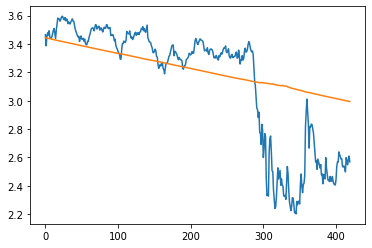

In [169]:
#Comparison
sarimax_comparison_test(array1 = y_aal_train_log, order1 = (0,1,1), order2 = (0,1,1,1), test = graph_aal_test)

#### SARIMAX follows the general trend of the stock price

In [170]:
#Forecast
aal_forecast_sarimax = sarimax_forecast_stock(array1 = y_aal_train_log, order1 = (0,1,1), order2 = (0,1,1,1))
df_aal_forecast = pd.DataFrame({'Price': aal_forecast_sarimax, 'Time': [i for i in range(2139, 2139 + 865)]})
df_aal_forecast = df_aal_forecast.set_index('Time')
graph_aal_sarimax = pd.concat([pd.DataFrame(df_log_train['AAL']).reset_index(drop = True), df_aal_forecast], axis = 0)

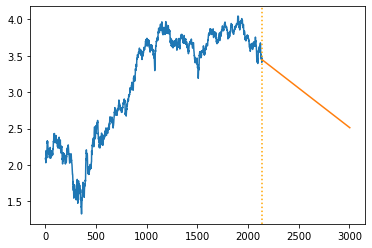

In [171]:
#Plot the projectioms
plt.plot(graph_aal_sarimax)
plt.axvline(2139, color = 'Orange', linestyle = 'dotted')
plt.show()

#### SARIMAX is also telling us that American Airlines stock price is falling.

### Tesla

In [172]:
# Do the validation
sarimax_validation(y_train = train_tsla, y_test = test_tsla)

(0, 0, 0, 0) : Error of: 2.84473257993231
(0, 0, 0, 1) : Error of: 2.84473257993231
(0, 0, 0, 2) : Error of: 2.84473257993231
(0, 0, 1, 0) : Error of: 2.839842093335547
(0, 0, 1, 1) : Error of: 2.839842093335547
(0, 0, 1, 2) : Error of: 2.8370349611704686
(0, 0, 2, 0) : Error of: 2.846131149091436
(0, 0, 2, 1) : Error of: 2.846131149091436
(0, 0, 2, 2) : Error of: 2.8422647968121617
(0, 1, 0, 1) : Error of: 335.0621060612821
(0, 1, 0, 2) : Error of: 33.07424432627181
(0, 1, 1, 1) : Error of: 13.709217395772118
(0, 1, 1, 2) : Error of: 8.026034773180696
(0, 1, 2, 1) : Error of: 2.777194129148216
(0, 1, 2, 2) : Error of: 8.008297536788241
(0, 2, 0, 1) : Error of: 1349482257968.1736
(0, 2, 0, 2) : Error of: 6908481690.829098
(0, 2, 1, 1) : Error of: 802.6728775049099
(0, 2, 1, 2) : Error of: 53.45776594459165
(0, 2, 2, 1) : Error of: 3.6769663757356135
(0, 2, 2, 2) : Error of: 756.235381098715
(1, 0, 0, 0) : Error of: 2.8561490348773524
(1, 0, 0, 1) : Error of: 2.8561490348773524
(1, 0, 0

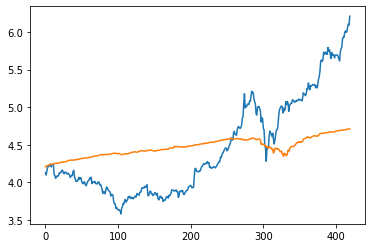

In [173]:
#Comparison
sarimax_comparison_test(array1 = y_tsla_train_log, order1 = (0,1,1), order2 = (0,1,1,2), test = graph_tsla_test)

#### SARIMAS follows the general trend as well for Tesla.

In [174]:
#Forecast
tsla_forecast_sarimax = sarimax_forecast_stock(array1 = y_tsla_train_log, order1 = (0,1,1), order2 = (0,1,1,2))
df_tsla_forecast = pd.DataFrame({'Price': tsla_forecast_sarimax, 'Time': [i for i in range(2139, 2139 + 865)]})
df_tsla_forecast = df_tsla_forecast.set_index('Time')
graph_tsla_sarimax = pd.concat([pd.DataFrame(df_log_train['TSLA']).reset_index(drop = True), df_tsla_forecast], axis = 0)

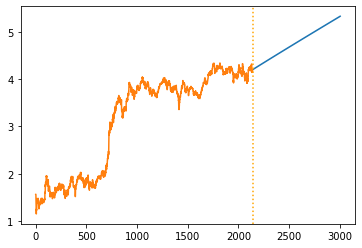

In [175]:
#Plot the projectioms
plt.plot(graph_tsla_sarimax)
plt.axvline(2139, color = 'Orange', linestyle = 'dotted')
plt.show()

#### From SARIMAX we are concluding that Tesla stock price is icreasing in a steeper way.

### Insights

- There is not a better model between Arima o Sarimax. The model I need to choose depends on how the model performs comparing it with the behavior of the stock. It is important to mention that since this is a model, it may go wrong with the predictions.


- For each stock, we are analyzing what may happen in the future

#### JKS 

- For JKS. one models says the stock price may decrease and the other model says stock price may appreciate in the close future. According to both models, the increase/decrease is going to be very controlled which make this a very safe investment opportunity. 

#### American Airlines

- This a very interesting one since it is a company highly affected because of covid. The American Airlines stock price has fell down on the last months. However, it is safe to assume in the future the stock price may increase again because the world would be recover from covid and additionally, the normal flights will return to normality. However, due to the tendency, both models say stock price may depreciate which makes this stock a very risky investment.

#### Tesla

- This is maybe the most difficult stock to analyze because of the company. It has hugely increasing their stock price on the last months, and SARIMAX supports it is going to continue this way. However, ARIMA says stock price may decrease. I would say the stock price may continue appreciating since it has a momentum, but it is likely to be controlled and not dramatically as it had occured. 

### Recommendations

- If you don't want unexpected behavior, according to the models, JKS may be the best option for you. American Airlines and Tesla had more unexpected behavior.

- It is still important to mention the some influence between the oil prices and the stocks behavior. JKS is not very correlated, but a decrease in oil price suppose an increase on the stock price for some reason. Now, if oil price decrease, American Airline's stock price decrease as well because they are highly correlated. Finally, Tesla and Oil Price have negative correlation between them, so a decrease in stock price is supposing an increase on Tesla stock price.  

- If oil price continues going down, it would be a better option to invest in Tesla or JKS rather than American airlines because of the close relation with the oil price and the american airlines stock price. If oil price goes up, American Airlines may be the best option to invest in.